In [1]:
# Standard python helper libraries.

import json, os, re, shutil, sys, time
import itertools, collections
from importlib import reload
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# NumPy and SciPy for matrix ops
import numpy as np
import scipy.sparse
import pandas as pd
import tensorflow as tf
assert(tf.__version__.startswith("1."))
from sklearn.cross_validation import train_test_split

# NLTK for NLP utils
import nltk
import gzip
from collections import namedtuple
import tflearn
# Helper libraries
from common import vocabulary, tf_embed_viz, glove_helper
from common import utils; reload(utils)

from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_curve, auc


/home/arunima/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/arunima/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Using pretrained GLove embeddings
hands = glove_helper.Hands(ndim=50)  # 50, 100, 200, 300 dim are available

Loading vectors from data/glove/glove.6B.zip
Parsing file: data/glove/glove.6B.zip:glove.6B.50d.txt
Found 400,000 words.
Parsing vectors... Done! (W.shape = (400003, 50))


In [3]:
hands.shape

(400003, 50)

In [4]:
#Function to read the amazon review data files
def parse(path):
  print('start parse')
  start_parse = time.time()
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
  end_parse = time.time()
  print('end parse with time for parse',end_parse - start_parse)

def getDF(path):
  print('start getDF')
  start = time.time()
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  print('end getDF')
  end = time.time()
  print('time taken to load data = ',end-start)
  return pd.DataFrame.from_dict(df, orient='index')
#df = getDF('reviews_Toys_and_Games.json.gz') #old def function corresponding to the step bt step vectorization

In [5]:
df_hnk = getDF('reviews_Home_and_Kitchen.json.gz')

start getDF
start parse
end parse with time for parse 247.7467555999756
end getDF
time taken to load data =  247.7471568584442


In [ ]:
df_vid = getDF('reviews_Video_Games.json.gz')

In [5]:
df_aut = getDF('reviews_Automotive.json.gz')

start getDF
start parse
end parse with time for parse 64.39745140075684
end getDF
time taken to load data =  64.39804863929749


In [6]:
df_toys = getDF('reviews_Toys_and_Games.json.gz')

start getDF
start parse
end parse with time for parse 105.62234997749329
end getDF
time taken to load data =  105.62298202514648


In [7]:
#Create train,dev,test split
from sklearn.model_selection import train_test_split
train_toys,devtest = train_test_split(df_toys, test_size=0.4, random_state=42)
dev_toys,test_toys = train_test_split(devtest,test_size = 0.5, random_state=42)
print('Toy reviews train, dev and test set dataframe shape:',train_toys.shape,dev_toys.shape,test_toys.shape)

#For Video games reviews
# train_vid,devtest = train_test_split(df_vid, test_size=0.4)
# dev_vid,test_vid = train_test_split(devtest,test_size = 0.5)
# print('Video games reviews train, dev and test set dataframe shape:',train_vid.shape,dev_vid.shape,test_vid.shape)

#For Auto reviews
train_aut,devtest = train_test_split(df_aut, test_size=0.4)
dev_aut,test_aut = train_test_split(devtest,test_size = 0.5)
print('Auto reviews train, dev and test set dataframe shape:',train_aut.shape,dev_aut.shape,test_aut.shape)

#For Home and Kitchen reviews
# train_hnk,devtest = train_test_split(df_hnk, test_size=0.4, random_state=42)
# dev_hnk,test_hnk = train_test_split(devtest,test_size = 0.5, random_state=42)
# print('Home and Kitchen reviews train, dev and test set dataframe shape:',train_hnk.shape,dev_hnk.shape,test_hnk.shape)

Toy reviews train, dev and test set dataframe shape: (1351662, 9) (450554, 9) (450555, 9)
Auto reviews train, dev and test set dataframe shape: (824260, 9) (274754, 9) (274754, 9)


In [8]:
#checking that we have different product ids
print(train_toys.head(2))
print(dev_toys.head(2))

             reviewerID        asin reviewerName helpful  \
1916352  A3I1XP89YM02QN  B009GXSBCG       Sleepy  [0, 0]   
1814240   ADDYT3AUNIIGR  B0085Y3YV0   wetarugula  [0, 0]   

                                                reviewText  overall  \
1916352  Son collects DC and Marvel comic collectables....      5.0   
1814240  No complaints here. They are a bit thinner tha...      4.0   

              summary  unixReviewTime  reviewTime  
1916352  Collectables      1389225600  01 9, 2014  
1814240        Great!      1388707200  01 3, 2014  
             reviewerID        asin       reviewerName helpful  \
1736076   AMAHICM9D5E5H  B007HE310I  Deborah J Rumsley  [0, 0]   
1208641  A3FSNQS8T99H1N  B003NVJ7WK          ralechner  [0, 0]   

                                                reviewText  overall  \
1736076  My 2 year old grandson likes to play with his ...      4.0   
1208641  Although there are many parts here, pots, pans...      5.0   

                                    

In [9]:
#Function to create a smaller sized train and dev data set. Enables testing accuracy for different sizes.
#Also binarizes the labels. Ratings of 1,2 and to 0; Ratings of 4,5 to 1.

def set_df_size(size,data_train,data_dev):
    size_train = size
    len_max_train = data_train[data_train.overall!=3].shape[0] #max possible length of train data set taking out the 3 ratings.
    #print("Number of reviews with ratings != 3 in train set",len_max_train)
    temp_size_train = min(len_max_train,size_train)

    len_max_dev = data_dev[data_dev.overall!=3].shape[0]
    #print("Number of reviews with ratings != 3 in dev set",len_max_dev)
    temp_size_dev = min(len_max_dev,int(0.3*temp_size_train)) #making the dev set about 0.3 times the train set.

    temp_train_data = data_train[data_train.overall != 3][:temp_size_train]
    #print('Size of train data',temp_train_data.shape)
    #print(temp_train_data.groupby('overall').count())
    #print(temp_train_toys[:5])

    temp_dev_data = data_dev[data_dev.overall!=3][:temp_size_dev]
    #print('Size of dev data',temp_dev_data.shape)
    #print(temp_dev_data.groupby('overall').count())
    #print(temp_dev_data[:2])
    
    #Binarize ratings
    temp_train_y = np.zeros(temp_size_train)
    temp_train_y[temp_train_data.overall > 3] = 1
    temp_dev_y = np.zeros(temp_size_dev)
    temp_dev_y[temp_dev_data.overall>3] = 1
    #print('binarized y shape',temp_train_y.shape,temp_dev_y.shape)
    #print(temp_dev_y[:20],data_dev.overall[:20])
    return temp_train_data,temp_dev_data,temp_train_y,temp_dev_y

In [10]:
list_df = ['toys','vid','aut','hnk'] #list of keys that refer to each dataframe. Adding a new dataframe would require updating this list
dict_train_df = {} #Dict to store train input data frame for each domain, can be accessed by using domain name as key
dict_dev_df = {} #Dict to store dev input data frame for each domain, can be accessed by using domain name as key
dict_train_y = {} #Dict to store binarized train data label for each domain
dict_dev_y = {} #Dict to store binarized dev data label for each domain
#print(len(dict_train_df))

def create_sized_data(size = 10000):
    size_train = size #Set size of train set here. This is a hyperparameter.
    key = list_df[0]
    # print('Toys reviews\n')
    dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_toys,dev_toys)
#     #print('\n Video games reviews\n')
#     key = list_df[1]
#     dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_vid,dev_vid)
    # print('\n Auto reviews\n')
    key = list_df[2]
    dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_aut,dev_aut)
#     #print('\n Home and Kitchen reviews\n')
#     key = list_df[3]
#     dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_hnk,dev_hnk)
#print(len(dict_train_df))

In [26]:
list_df = ['toys','vid','aut','hnk']
train_data_size = 50000
create_sized_data(train_data_size)
print(dict_train_df['toys'].shape)

(10000, 9)


In [12]:
import nltk
#nltk.download('punkt')
from nltk import word_tokenize

In [29]:
#Preprocessing steps - old code. Don't need to run. Vocab_processor is much faster.

#Changing to nltk punkt tokenizer as the periods are not getting removed
print(dict_train_df['hnk'].shape[0])

train_cnt = collections.Counter()
x_train_tokens_list = []
start = time.time()
for i in range(dict_train_df['hnk'].shape[0]):
    #print(dict_train_df['hnk'].iloc[i][2])
    x_train_tokens = word_tokenize(dict_train_df['hnk'].iloc[i][4])    

    #2. changing to lowercase and replacing numbers(are we losing any context by replacing all numbers in the review test?)
    x_tokens_canonical = utils.canonicalize_words(x_train_tokens)   
    x_train_tokens_list.append(x_tokens_canonical)
    
    if i%10000 == 0:
        print(i) 
    #3. Build vocabulary
    for items in x_tokens_canonical:
            train_cnt[items] += 1
            
vocab = vocabulary.Vocabulary(train_cnt, size=None)  # size=None means unlimited
total_words = sum(train_cnt.values())
print("x_train_tokens_list length", len(x_train_tokens_list))
print("Vocabulary size: {:,}".format(vocab.size))
#print("Vocabulary dict: ", vocab.word_to_id)
print("Total words ",total_words )


10000
0
x_train_tokens_list length 10000
Vocabulary size: 24,801
Total words  800308


In [30]:
print(len(x_train_tokens_list[1]))
print(x_train_tokens_list[1])
print(len(x_train_tokens_list[0]))
print(x_train_tokens_list[0])

40


In [34]:
#Converting all reviews to ids 
train_id_list = []
for item in x_train_tokens_list:
    train_id_list.append(vocab.words_to_ids(item))
    
test_id_list = []
for item in x_test_tokens_list:
    test_id_list.append(vocab.words_to_ids(item))  

NameError: name 'x_test_tokens_list' is not defined

In [35]:
print((x_train_tokens_list[1]))
print(max((train_id_list)))
review_lengths = [len(review) for review in x_train_tokens_list]
print("Shortest review:", min(review_lengths))
print("Longest review:",max(review_lengths))
pd.DataFrame(review_lengths).describe()
print('90th percentile',pd.DataFrame(review_lengths).quantile(0.9))

['this', 'item', 'was', 'well', 'made', ',', 'and', 'the', 'instructions', 'for', 'personalizing', 'it', 'by', 'the', 'persons', 'for', 'whom', 'i', 'bought', 'it', 'were', 'clear', 'and', 'uncomplicated', '.', 'so', 'i', 'hope', 'they', 'will', 'enjoy', 'putting', 'it', 'together', 'with', 'their', 'many', 'wine', 'corks', '.']


[]

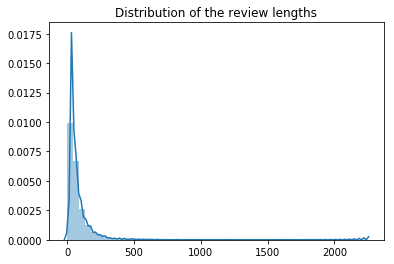

In [38]:
ax = plt.axes()
sns.distplot(review_lengths)
ax.set_title("Distribution of the review lengths")
plt.plot()

#Based on the above, we are setting a max_length of 150

In [13]:
#vocab_processor = tflearn.data_utils.VocabularyProcessor(max_length, min_frequency=0)
#Note : This function seems to be deprecated. Another function I ran into 
# tflearn.data_utils.VocabularyProcessor (max_document_length, min_frequency=3, vocabulary=None, tokenizer_fn=None)

def process_inputs(key, vocab_processor):
    
    # For simplicity, we call our features x and our outputs y
    start_vectorize = time.time()
    x_train = dict_train_df[key].reviewText
    y_train = dict_train_y[key]
    x_dev = dict_dev_df[key].reviewText
    y_dev = dict_dev_y[key]
    print(x_train.shape)
    
    # Train the vocab_processor from the training set
    x_train = vocab_processor.fit_transform(x_train)
    # Transform our test set with the vocabulary processor
    x_dev = vocab_processor.transform(x_dev)

    # We need these to be np.arrays instead of generators
    x_train = np.array(list(x_train))
    print(x_train.shape)
    x_dev = np.array(list(x_dev))
    y_train = np.array(y_train).astype(int)
    y_dev = np.array(y_dev).astype(int)
    
#     y_train = tf.expand_dims(y_train,1)
#     y_dev = tf.expand_dims(y_dev,1)
    print('y train shape',y_train.shape)

    V = len(vocab_processor.vocabulary_)
    print('Total words: %d' % V)
    end_vectorize = time.time()
    print('Time taken to vectorize %d size dataframe'%x_train.shape[0],end_vectorize-start_vectorize)

    # Return the transformed data and the number of words
    return x_train, y_train, x_dev, y_dev, V

In [27]:
list_df = ['toys','aut'] #redefining here to limit further analysis to these domains only.

In [28]:
#Converting reviews to ids for all domains and add padding.

# Hyperparameters
min_frequency = 5
max_length = 150

dict_vectorizers = {} #Dict to store the vocab_processor fit on each domain
dict_train_ids = {} #Dict to store train data reviews as sparse matrix of word ids
dict_dev_ids = {} #Dict to store dev data reviews as sparse matrix of word ids
dict_cnn = {} #Dict to store cnn model developed on each domain. Assumes input features are developed using the corresponding count_vectorizer
dict_dev_ypred = {} #Dict to store dev predictions
dict_vocab_len = {} #Store vocab length of each domain
for key in list_df:
    
    #Converting ratings to tokenized word id counts as a sparse matrix using count_vectorizer
    dict_vectorizers[key] = tflearn.data_utils.VocabularyProcessor(max_length, min_frequency=min_frequency)
    print(key)
    dict_train_ids[key], dict_train_y[key],dict_dev_ids[key], dict_dev_ypred[key], dict_vocab_len[key] = process_inputs(key,dict_vectorizers[key])
    
    print("Number words in training corpus for",key,(dict_vocab_len[key]))
    print(key,'dataset id shapes',dict_train_ids[key].shape, dict_dev_ids[key].shape)

    #Print a few examples for viewing
    print('sample review for domain',key, dict_train_df[key].reviewText.iloc[3],'\n')
    print('corresponding ids\n',dict_train_ids[key][3],'\n')

toys
(10000,)
(10000, 150)
y train shape (10000,)
Total words: 5993
Time taken to vectorize 10000 size dataframe 1.5661492347717285
Number words in training corpus for toys 5993
toys dataset id shapes (10000, 150) (3000, 150)
sample review for domain toys It's just the model I was hoping for and more. It's challenging and has given me something more to learn in developing my model building skills. Revell as always makes good models to build! 

corresponding ids
 [ 111   38    1  319    6   14 1067    8    2   51  111  755    2   42  577
   97  225   51    3  366   12 4337   15  319  535  858 5014   22  272  211
   61  782    3  389    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 

In [27]:
#code to determine max_length for vectorization.
#Output below was generated using max_length of 1000 in vectorizer first.
for key in list_df:
    length = np.count_nonzero(dict_train_ids[key],axis = 1)
    print(key,length.shape)
    print(np.histogram(length,bins = 20))
    print("Number less than 100",np.count_nonzero(length[length <= 100]))
    print("Number less than 150",np.count_nonzero(length[length <= 150]))
    print("Number less than 175",np.count_nonzero(length[length <= 175]))
    print("Number less than 200",np.count_nonzero(length[length <= 200]))

toys (5000,)
(array([2879, 1248,  460,  182,   86,   47,   35,   18,   18,    2,    6,
          5,    1,    2,    4,    3,    0,    0,    2,    2]), array([   0. ,   47.9,   95.8,  143.7,  191.6,  239.5,  287.4,  335.3,
        383.2,  431.1,  479. ,  526.9,  574.8,  622.7,  670.6,  718.5,
        766.4,  814.3,  862.2,  910.1,  958. ]))
Number less than 100 4192
Number less than 150 4613
Number less than 175 4718
Number less than 200 4790
aut (5000,)
(array([3180, 1102,  362,  177,   81,   38,   24,   10,    7,    8,    1,
          4,    0,    1,    2,    0,    0,    1,    0,    2]), array([   1.  ,   49.85,   98.7 ,  147.55,  196.4 ,  245.25,  294.1 ,
        342.95,  391.8 ,  440.65,  489.5 ,  538.35,  587.2 ,  636.05,
        684.9 ,  733.75,  782.6 ,  831.45,  880.3 ,  929.15,  978.  ]))
Number less than 100 4301
Number less than 150 4654
Number less than 175 4759
Number less than 200 4826


In [29]:
#Model parameters

#embed_dim = 50 #use when not using pre-trained embeddings
embed_dim = hands.shape[1]
lstm_size = 128
lstm_layers = 1
attention_size = 50
learning_rate = 0.01
momentum = 0.9
keep_prob = 0.8
evaluate_train = 1 # of epochs at which to print test accuracy
evaluate_dev = 1 # of epochs at which to estimate and print dev accuracy
time_print = 4 # of epochs at which to print time taken
num_classes = 2
num_epochs = 15
batch_size=128

# out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", "cnn"))
# print("Model saving  to {}\n".format(out_dir))

In [18]:
class TextRNN(object):

    """
    RNN for text classification.
    Uses an embedding layer, followed by an RNN and softmax layer.
    """

    def __init__(self, sequence_length, lstm_size, num_classes, vocab_size, learning_rate, momentum, embedding_size, 
                 gl_embed):

        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.int32, [None], name="input_y")
        self.seq_length = tf.placeholder(tf.int32,[None])
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer

        with tf.name_scope("embedding"):
            #self.W = tf.get_variable("W_in",[vocab_size, embedding_size],initializer =tf.random_uniform_initializer(0,1)) #from wildML
            self.W=tf.get_variable(name="embedding_",shape=gl_embed.shape,
                                       initializer=tf.constant_initializer(gl_embed),trainable=True)
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            print('embedded_chars',self.embedded_chars.get_shape())
            
        with tf.name_scope("rnn_layer"):
            basic_cell = tf.contrib.rnn.BasicLSTMCell(num_units = lstm_size)
            cell_drop = tf.contrib.rnn.DropoutWrapper(basic_cell,input_keep_prob = self.dropout_keep_prob)
            multi_layer_cell = tf.contrib.rnn.MultiRNNCell([cell_drop] * lstm_layers)
            outputs,states = tf.nn.dynamic_rnn(multi_layer_cell,self.embedded_chars,dtype = tf.float32)
            print('output from rnn',outputs.get_shape())

        with tf.name_scope("output"):
            self.scores = tf.contrib.layers.fully_connected(outputs[:,-1],num_classes,activation_fn = None)
            print('self.scores',self.scores.get_shape())
            self.predictions = tf.argmax(self.scores, 1, name="predictions")
            self.pred_proba = tf.nn.softmax(self.scores, name="pred_proba")
            print('self.predictions',self.predictions.get_shape())
            
        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses)
            #self.loss = tf.losses.mean_squared_error(self.input_y, self.scores)

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(tf.cast(self.predictions,tf.int32), self.input_y)
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")
#             correct_pred = tf.equal(tf.cast(tf.round(self.scores), tf.int32), self.input_y)
#             self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


        # AUC
#         with tf.name_scope("auc"):
#             false_pos_rate, true_pos_rate, _ = roc_curve(self.input_y, self.pred_proba[:,1])
#             self.auc = auc(false_pos_rate, true_pos_rate)
            
            
        max_grad_norm = 1.0
        with tf.name_scope('train'):
            #self.optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate,momentum=momentum,use_nesterov=True).minimize(self.loss)
            #Above is simple optimizer without gradient clipping
            
            #Below is code with gradient clipping
            optimizer_ = tf.train.AdamOptimizer(learning_rate = learning_rate)
            gradients, variables = zip(*optimizer_.compute_gradients(self.loss))
            gradients, _ = tf.clip_by_global_norm(gradients, max_grad_norm)
            self.train_step_ = optimizer_.apply_gradients(zip(gradients, variables))

In [65]:
def attention(inputs, attention_size, time_major=False, return_alphas=False):

    """
    Attention mechanism layer which reduces RNN/Bi-RNN outputs with Attention vector.

    The idea was proposed in the article by Z. Yang et al., "Hierarchical Attention Networks for Document Classification", 2016: http://www.aclweb.org/anthology/N16-1174.
    Variables notation is also inherited from the article

    Args:
        inputs: The Attention inputs.
            Matches outputs of RNN/Bi-RNN layer (not final state):
                In case of RNN, this must be RNN outputs `Tensor`:
                    If time_major == False (default), this must be a tensor of shape:
                        `[batch_size, max_time, cell.output_size]`.
                    If time_major == True, this must be a tensor of shape:
                        `[max_time, batch_size, cell.output_size]`.

                In case of Bidirectional RNN, this must be a tuple (outputs_fw, outputs_bw) containing the forward and
                the backward RNN outputs `Tensor`.

                    If time_major == False (default),
                        outputs_fw is a `Tensor` shaped:
                        `[batch_size, max_time, cell_fw.output_size]`
                        and outputs_bw is a `Tensor` shaped:
                        `[batch_size, max_time, cell_bw.output_size]`.

                    If time_major == True,
                        outputs_fw is a `Tensor` shaped:
                        `[max_time, batch_size, cell_fw.output_size]`
                        and outputs_bw is a `Tensor` shaped:
                        `[max_time, batch_size, cell_bw.output_size]`.

        attention_size: Linear size of the Attention weights.
        time_major: The shape format of the `inputs` Tensors.

            If true, these `Tensors` must be shaped `[max_time, batch_size, depth]`.
            If false, these `Tensors` must be shaped `[batch_size, max_time, depth]`.
            Using `time_major = True` is a bit more efficient because it avoids
            transposes at the beginning and end of the RNN calculation.  However,
            most TensorFlow data is batch-major, so by default this function
            accepts input and emits output in batch-major form.

        return_alphas: Whether to return attention coefficients variable along with layer's output.
            Used for visualization purpose.

    Returns:

        The Attention output `Tensor`.

In case of RNN, this will be a `Tensor` shaped:
            `[batch_size, cell.output_size]`.

        In case of Bidirectional RNN, this will be a `Tensor` shaped:
            `[batch_size, cell_fw.output_size + cell_bw.output_size]`.

    """

    if isinstance(inputs, tuple):
        # In case of Bi-RNN, concatenate the forward and the backward RNN outputs.
        inputs = tf.concat(inputs, 2)

    if time_major:
        # (T,B,D) => (B,T,D)
        inputs = tf.array_ops.transpose(inputs, [1, 0, 2])

    hidden_size = inputs.shape[2].value  # D value - hidden size of the RNN layer

    # Trainable parameters
    w_omega = tf.Variable(tf.random_normal([hidden_size, attention_size], stddev=0.1))
    b_omega = tf.Variable(tf.random_normal([attention_size], stddev=0.1))
    u_omega = tf.Variable(tf.random_normal([attention_size], stddev=0.1))
    print('Shapes of attention parameters w,b,u',w_omega.get_shape(),b_omega.get_shape(),u_omega.get_shape())

    with tf.name_scope('v'):

        # Applying fully connected layer with non-linear activation to each of the B*T timestamps;
        #  the shape of `v` is (B,T,D)*(D,A)=(B,T,A), where A=attention_size
        v = tf.tanh(tf.tensordot(inputs, w_omega, axes=1) + b_omega)

    # For each of the timestamps its vector of size A from `v` is reduced with `u` vector
    vu = tf.tensordot(v, u_omega, axes=1, name='vu')  # (B,T) shape
    #print('shape of vu',vu.get_shape)
    alphas = tf.nn.softmax(vu, name='alphas')         # (B,T) shape
    #print('shape of alphas',alphas.get_shape)

    # Output of (Bi-)RNN is reduced with attention vector; the result has (B,D) shape
    output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), 1)
    output.set_shape((None,hidden_size)) #Set shape explicity as fully connected function gives an error otherwise in textRNNwithA
    print('shape of attention output',output.get_shape())

    if not return_alphas:
        return output
    else:
        return output, alphas

In [61]:
a = tf.placeholder(tf.int32,[2,2])
b = tf.placeholder(tf.int32,[2,2])
feed = {a:[[1,2],[3,4]],b:[[5,6],[7,8]]}
print(b.get_shape)
print(a.get_shape)
c = tf.tensordot(a,b,axes = 1)
print(c.get_shape)

<bound method Tensor.get_shape of <tf.Tensor 'Placeholder_19:0' shape=(2, 2) dtype=int32>>
<bound method Tensor.get_shape of <tf.Tensor 'Placeholder_18:0' shape=(2, 2) dtype=int32>>
<bound method Tensor.get_shape of <tf.Tensor 'Tensordot_1:0' shape=<unknown> dtype=int32>>


In [43]:
class TextRNNwithA(object):
    """
    RNN with Attention for text classification.
    Uses an embedding layer, followed by an RNN and softmax layer.
    """

    def __init__(self, sequence_length, lstm_size, num_classes, vocab_size, learning_rate, momentum, embedding_size, 
                 gl_embed):

        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.int32, [None], name="input_y")
        self.seq_length = tf.placeholder(tf.int32,[None])
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer

        with tf.name_scope("embedding"):
            #self.W = tf.get_variable("W_in",[vocab_size, embedding_size],initializer =tf.random_uniform_initializer(0,1)) #from wildML
            self.W=tf.get_variable(name="embedding_",shape=gl_embed.shape,
                                       initializer=tf.constant_initializer(gl_embed),trainable=True)
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            print('embedded_chars',self.embedded_chars.get_shape())
            
        with tf.name_scope("rnn_layer"):
            basic_cell = tf.contrib.rnn.BasicLSTMCell(num_units = lstm_size)
            cell_drop = tf.contrib.rnn.DropoutWrapper(basic_cell,input_keep_prob = self.dropout_keep_prob)
            multi_layer_cell = tf.contrib.rnn.MultiRNNCell([cell_drop] * lstm_layers)
            outputs,states = tf.nn.dynamic_rnn(multi_layer_cell,self.embedded_chars,dtype = tf.float32)
            print('output from rnn',outputs.get_shape())
            
        with tf.name_scope("attention"):
            attention_output, alphas = attention(outputs,attention_size, return_alphas = True)
            print('attention_output',attention_output.get_shape())

        with tf.name_scope("output"):
            self.scores = tf.contrib.layers.fully_connected(attention_output,num_classes,activation_fn = None) #modified to take the output of attention
            print('self.scores',self.scores.get_shape())
            self.predictions = tf.argmax(self.scores, 1, name="predictions")
            self.pred_proba = tf.nn.softmax(self.scores, name="pred_proba")
            print('self.predictions',self.predictions.get_shape())
            
        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses)
            #self.loss = tf.losses.mean_squared_error(self.input_y, self.scores)

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(tf.cast(self.predictions,tf.int32), self.input_y)
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")
#             correct_pred = tf.equal(tf.cast(tf.round(self.scores), tf.int32), self.input_y)
#             self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


        # AUC
#         with tf.name_scope("auc"):
#             false_pos_rate, true_pos_rate, _ = roc_curve(self.input_y, self.pred_proba[:,1])
#             self.auc = auc(false_pos_rate, true_pos_rate)
            
            
        max_grad_norm = 1.0
        with tf.name_scope('train'):
            #self.optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate,momentum=momentum,use_nesterov=True).minimize(self.loss)
            #Above is simple optimizer without gradient clipping
            
            #Below is code with gradient clipping
            optimizer_ = tf.train.AdamOptimizer(learning_rate = learning_rate)
            gradients, variables = zip(*optimizer_.compute_gradients(self.loss))
            gradients, _ = tf.clip_by_global_norm(gradients, max_grad_norm)
            self.train_step_ = optimizer_.apply_gradients(zip(gradients, variables))

In [19]:
def batch_generator(ids, labels, batch_size=100, Trainable=False):
            #ids is input, X_train
            #shuffle between epochs while training only
            
            n_batches = len(ids)//batch_size
            ids, labels = ids[:n_batches*batch_size], labels[:n_batches*batch_size]
            if Trainable:
                shuffle = np.random.permutation(np.arange(n_batches*batch_size))
                ids, labels = ids[shuffle], labels[shuffle]
   
            for ii in range(0, len(ids), batch_size):
                yield ids[ii:ii+batch_size], labels[ii:ii+batch_size]

In [44]:
##### Actual training loop:

def train_cnn(key, size=train_data_size):
     
    x_train = dict_train_ids[key]
    y_train = dict_train_y[key]
    x_dev = dict_dev_ids[key]
    y_dev = dict_dev_ypred[key]
    V = dict_vocab_len[key]
    
    with tf.Graph().as_default():

        with tf.Session() as sess:
        
            cnn = TextRNNwithA(sequence_length=x_train.shape[1], lstm_size = lstm_size, num_classes=num_classes, vocab_size=V, learning_rate = learning_rate,
                        momentum = momentum, embedding_size=embed_dim, gl_embed = hands.W)
            
            sess.run(tf.global_variables_initializer())
            print('completed cnn creation')

#             # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
#             size_folder =  "size_" + str(size) 
#             out_dir  = os.path.abspath(os.path.join(os.path.curdir, "runs", key, size_folder))
#             #out_dir  = os.path.abspath(os.path.join(os.path.curdir, "runs", key))
#             checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
#             model_name = key 
#             checkpoint_prefix = os.path.join(checkpoint_dir, model_name  + "_model")
#             if not os.path.exists(checkpoint_dir):
#                 os.makedirs(checkpoint_dir)
#             saver = tf.train.Saver(tf.global_variables())
            
            # Write vocabulary
            ## vocab_processor.save(os.path.join(out_dir, "vocab"))
            
            print('# batches =', len(x_train)//batch_size)
            start = time.time()
            for e in range(num_epochs):
                    
                #sum_scores = np.zeros((batch_size*(len(x_train)//batch_size),1))
                total_loss = 0
                total_acc = 0
                total_auc = 0
                
                for i, (x, y) in enumerate(batch_generator(x_train, y_train, batch_size, Trainable=True), 1):
                    feed = {cnn.input_x: x, cnn.input_y: y, cnn.dropout_keep_prob: keep_prob, cnn.seq_length: np.count_nonzero(x,axis = 1)}
                    # _, loss, accuracy = sess.run([cnn.optimizer,cnn.loss, cnn.accuracy],feed_dict = feed)
                    _, loss, accuracy = sess.run([cnn.train_step_,cnn.loss, cnn.accuracy],feed_dict = feed)
                    total_loss += loss*len(x)
                    total_acc += accuracy*len(x)
                    
                    #total_auc += auc*len(x)
                    
                if e%evaluate_train==0:
                    avg_loss = total_loss/(batch_size*(len(x_train)//batch_size))
                    avg_acc = total_acc/(batch_size*(len(x_train)//batch_size))
                    #avg_auc = total_auc/(batch_size*(len(x_train)//batch_size))
                   # print("Train epoch {}, average loss {:g}, average accuracy {:g},average auc {:g}".format(e, avg_loss, avg_acc, avg_auc))
                    print("Train epoch {}, average loss {:g}, average accuracy {:g},".format(e, avg_loss, avg_acc))

                if e%evaluate_dev==0:
                    
                    total_loss = 0
                    total_acc = 0
                    num_batches = 0
                    total_auc = 0
                    y_pred = []
                    y_pred_proba = []
                    y_shuffled = []
                    total_batch_acc = 0
                    
                    for ii, (x, y) in enumerate(batch_generator(x_dev, y_dev, batch_size, Trainable=False), 1):
                        
                        feed_dict = {cnn.input_x: x, cnn.input_y: y, cnn.dropout_keep_prob: 1.0, cnn.seq_length: np.count_nonzero(x,axis = 1)}
                        #loss, accuracy, auc = sess.run([cnn.loss, cnn.accuracy, cnn.auc],feed_dict)
                       # batch_pred,batch_pred_proba,loss, accuracy  = sess.run([cnn.loss, cnn.accuracy],feed_dict)
                        batch_pred,batch_pred_proba,loss, accuracy  = sess.run([cnn.predictions, cnn.pred_proba, cnn.loss, cnn.accuracy],feed_dict)
                        total_loss += loss*len(x)
                        total_acc += accuracy*len(x)
                        
                        batch_accuracy= np.sum(y==batch_pred)/y.shape[0]
                        total_batch_acc += batch_accuracy
                        y_pred= np.concatenate([y_pred, batch_pred])
                        y_pred_proba= np.concatenate([y_pred_proba, batch_pred_proba[:,1]])
                        y_shuffled = np.concatenate([y_shuffled, y])
                        
                        num_batches += 1
                        
                    avg_loss = total_loss/(num_batches*batch_size)
                    avg_acc = total_acc/(num_batches*batch_size)
                    
                    print('y_dev.shape',y_dev.shape)
                    print('y_shuffled.shape',y_shuffled.shape)
                    
                    false_pos_rate, true_pos_rate, _ = roc_curve(y_shuffled, y_pred_proba)  
                    roc_auc = auc(false_pos_rate, true_pos_rate)
                    f1_pos = f1_score(y_shuffled, y_pred, average = None)[1]
                    f1_neg = f1_score(y_shuffled, y_pred, average = None)[0]
                    f1_avg = f1_score(y_shuffled, y_pred, average = 'macro')
                    
                #time_str = datetime.datetime.now().isoformat()
                    print("\t\tDev epoch {}, avg loss {:g}, accuracy {:g}, auc {:g}, F1 pos {:g}, F1 neg {:g}, F1 avg {:g}"
                          .format(e, avg_loss, avg_acc, roc_auc, f1_pos, f1_neg, f1_avg))

                if e%time_print == 0:
                    end = time.time()
                    print("\t\t\t\t    Time taken for",e,"epochs = ", end-start)
                                        
        # Save model weights for future use.       
            #save_path = saver.save(sess, checkpoint_prefix, global_step=20,write_meta_graph=False)
#             save_path = saver.save(sess, checkpoint_prefix)
#             print("Saved model", model_name, save_path)
            
            #calculate predictions and prediction probability    
#             feed_dict={cnn.input_x:x_dev, cnn.input_y: y_dev, cnn.dropout_keep_prob: 1.0}
#             y_pred, y_pred_proba = sess.run([cnn.predictions, cnn.pred_proba],feed_dict)
            #print(y_pred, y_pred_proba)

In [ ]:
#Create and train the rnn models for all domains in list_df
#Pass the size to save the model name with size in different folders

num_epochs = 12
list_df = ['toys']
size_train = train_data_size
for key in list_df:
    print(key, size_train)
    train_cnn(key, size=size_train)

toys 10000
embedded_chars (?, 150, 50)
output from rnn (?, 150, 128)
Shapes of attention parameters w,b,u (128, 50) (50,) (50,)
shape of attention output (?, 128)
attention_output (?, 128)
self.scores (?, 2)
self.predictions (?,)
completed cnn creation
# batches = 78
Train epoch 0, average loss 0.354425, average accuracy 0.864984,
y_dev.shape (3000,)
y_shuffled.shape (2944,)
		Dev epoch 0, avg loss 0.227731, accuracy 0.912704, auc 0.925208, F1 pos 0.949834, F1 neg 0.664052, F1 avg 0.806943
				    Time taken for 0 epochs =  74.45206379890442
Train epoch 1, average loss 0.163856, average accuracy 0.935897,
y_dev.shape (3000,)
y_shuffled.shape (2944,)
		Dev epoch 1, avg loss 0.204518, accuracy 0.918818, auc 0.938052, F1 pos 0.952795, F1 neg 0.710303, F1 avg 0.831549
Train epoch 2, average loss 0.108579, average accuracy 0.958133,
y_dev.shape (3000,)
y_shuffled.shape (2944,)
		Dev epoch 2, avg loss 0.22698, accuracy 0.920856, auc 0.93416, F1 pos 0.954052, F1 neg 0.71481, F1 avg 0.834431
T

### Observations : 

- Dropping sequence length in the multi_cnn_cell function immediately led to an improvement in the trainability of the RNN ie train loss did start dropping for train and dev, and finally dev accuracy improved all the way to 90%

- Adding gradient clipping does make a difference and enables the LSTM to train better.
- Increasing min_df from 2 to 5 allowed accuracy to improve a little bit more (0.5-1%) on a 10000 sample.

### Output of some runs

sample size = 50000. 
lstm_size = 50
embed_size = 50
min_df = 5

Train epoch 6, average loss 0.0821299, average accuracy 0.971875,
y_dev.shape (15000,)
y_shuffled.shape (14976,)
		Dev epoch 6, average loss 0.218732, average accuracy 0.931223, auc 0.950772, F1 pos 0.959734, F1 neg 0.76441, F1 avg 0.862072

#### sample size = 50000, lstm_size = 128, embed_size = 50, min_df = 5
        Train epoch 1, average loss 0.373705, average accuracy 0.859776,
y_dev.shape (15000,)
y_shuffled.shape (14976,)
		Dev epoch 1, average loss 0.227598, average accuracy 0.911525, auc 0.927889, F1 pos 0.948578, F1 neg 0.683393, F1 avg 0.815985
Train epoch 2, average loss 0.179789, average accuracy 0.93095,
y_dev.shape (15000,)
y_shuffled.shape (14976,)
		Dev epoch 2, average loss 0.185112, average accuracy 0.925414, auc 0.953655, F1 pos 0.956379, F1 neg 0.742923, F1 avg 0.849651
Train epoch 3, average loss 0.130883, average accuracy 0.951282,
y_dev.shape (15000,)
y_shuffled.shape (14976,)
		Dev epoch 3, average loss 0.178948, average accuracy 0.931757, auc 0.958147, F1 pos 0.96015, F1 neg 0.762657, F1 avg 0.861403
Train epoch 4, average loss 0.105596, average accuracy 0.96274,
y_dev.shape (15000,)
y_shuffled.shape (14976,)
		Dev epoch 4, average loss 0.189158, average accuracy 0.930155, auc 0.953904, F1 pos 0.959277, F1 neg 0.754805, F1 avg 0.857041
				    Time taken for 4 epochs =  1568.20579123497
Train epoch 5, average loss 0.0880419, average accuracy 0.96899,
y_dev.shape (15000,)
y_shuffled.shape (14976,)
		Dev epoch 5, average loss 0.197142, average accuracy 0.933226, auc 0.953946, F1 pos 0.961147, F1 neg 0.762696, F1 avg 0.861921
Train epoch 6, average loss 0.0776873, average accuracy 0.972837,
y_dev.shape (15000,)
y_shuffled.shape (14976,)
		Dev epoch 6, average loss 0.203607, average accuracy 0.929754, auc 0.951635, F1 pos 0.958583, F1 neg 0.768893, F1 avg 0.863738
Train epoch 7, average loss 0.0645518, average accuracy 0.977484,
y_dev.shape (15000,)
y_shuffled.shape (14976,)
		Dev epoch 7, average loss 0.223198, average accuracy 0.931824, auc 0.947381, F1 pos 0.960128, F1 neg 0.765017, F1 avg 0.862573

#### Sample size = 100000,  lstm_size = 128, embed_size = 50, min_df = 5
        Train epoch 0, average loss 0.401195, average accuracy 0.852643,
y_dev.shape (30000,)
y_shuffled.shape (29952,)
		Dev epoch 0, average loss 0.238714, average accuracy 0.906083, auc 0.919337, F1 pos 0.946422, F1 neg 0.619916, F1 avg 0.783169
				    Time taken for 0 epochs =  624.3892278671265
Train epoch 1, average loss 0.183042, average accuracy 0.929728,
y_dev.shape (30000,)
y_shuffled.shape (29952,)
		Dev epoch 1, average loss 0.166323, average accuracy 0.935029, auc 0.964439, F1 pos 0.961843, F1 neg 0.781447, F1 avg 0.871645
Train epoch 2, average loss 0.131615, average accuracy 0.950824,
y_dev.shape (30000,)
y_shuffled.shape (29952,)
		Dev epoch 2, average loss 0.160972, average accuracy 0.94184, auc 0.967205, F1 pos 0.966092, F1 neg 0.79578, F1 avg 0.880936
Train epoch 3, average loss 0.111825, average accuracy 0.958187,
y_dev.shape (30000,)
y_shuffled.shape (29952,)
		Dev epoch 3, average loss 0.160572, average accuracy 0.94194, auc 0.967076, F1 pos 0.966289, F1 neg 0.79096, F1 avg 0.878625
Train epoch 4, average loss 0.0959312, average accuracy 0.964889,
y_dev.shape (30000,)
y_shuffled.shape (29952,)
		Dev epoch 4, average loss 0.166863, average accuracy 0.939336, auc 0.966227, F1 pos 0.964291, F1 neg 0.798581, F1 avg 0.881436
				    Time taken for 4 epochs =  3135.383953809738
Train epoch 5, average loss 0.0864601, average accuracy 0.96869,
y_dev.shape (30000,)
y_shuffled.shape (29952,)
		Dev epoch 5, average loss 0.165132, average accuracy 0.938401, auc 0.966546, F1 pos 0.96383, F1 neg 0.79258, F1 avg 0.878205
Train epoch 6, average loss 0.0805708, average accuracy 0.971081,
y_dev.shape (30000,)
y_shuffled.shape (29952,)
		Dev epoch 6, average loss 0.179582, average accuracy 0.939236, auc 0.961596, F1 pos 0.964761, F1 neg 0.779554, F1 avg 0.872158
Train epoch 7, average loss 0.0728268, average accuracy 0.974202,
y_dev.shape (30000,)
y_shuffled.shape (29952,)
		Dev epoch 7, average loss 0.186312, average accuracy 0.939937, auc 0.963728, F1 pos 0.964908, F1 neg 0.791758, F1 avg 0.878333
Train epoch 8, average loss 0.0687276, average accuracy 0.975792,
y_dev.shape (30000,)
y_shuffled.shape (29952,)
		Dev epoch 8, average loss 0.186776, average accuracy 0.940271, auc 0.96068, F1 pos 0.965282, F1 neg 0.786388, F1 avg 0.875835
				    Time taken for 8 epochs =  5658.2309448719025
Train epoch 9, average loss 0.0643795, average accuracy 0.977153,
y_dev.shape (30000,)
y_shuffled.shape (29952,)
		Dev epoch 9, average loss 0.192174, average accuracy 0.938535, auc 0.958901, F1 pos 0.964034, F1 neg 0.788803, F1 avg 0.876419

### This is old code to build an LSTM from Anamika

In [59]:
lstm_size = 256
lstm_layers = 1
#batch_size = 50
batch_size = 128
learning_rate = 0.001
embed_size = hands.shape[1]
print(embed_size)

50


In [61]:
def build_rnn(gl_embed=hands.W,
              embed_size=embed_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              lstm_size=lstm_size,
              lstm_layers=lstm_layers):
    
    tf.reset_default_graph()
    
    #n_words = len(vocabulary_to_int)
    
    with tf.name_scope('inputs'):
        inputs_ = tf.placeholder(tf.int32,[None, None],name='inputs_')
    with tf.name_scope('labels'):
        labels_ = tf.placeholder(tf.int32,[None, None],name='labels_')
    with tf.name_scope('keep_prob'):    
        keep_prob = tf.placeholder(tf.float32,name='keep_prob')
        
    with tf.name_scope('embedding'):
#         embedding = tf.Variable(tf.random_normal((n_words,embed_size),-1,1),name='embedding_')
#         embed = tf.nn.embedding_lookup(embedding,inputs_)
        embedding=tf.get_variable(name="embedding_",shape=gl_embed.shape,
                                       initializer=tf.constant_initializer(gl_embed),trainable=False)
        embed = tf.nn.embedding_lookup(embedding, inputs_)
        
    with tf.name_scope("RNN_cells"):
        lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

        # Add dropout to the cell
        drop = tf.contrib.rnn.DropoutWrapper(lstm,output_keep_prob=keep_prob)

        # Stack up multiple LSTM layers, for deep learning
        cell = tf.contrib.rnn.MultiRNNCell([drop]*lstm_layers)
        
        with tf.name_scope("RNN_init_state"):
            # Getting an initial state of all zeros
            initial_state = cell.zero_state(batch_size, tf.float32)
    
    with tf.name_scope("RNN_forward"):
        outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state=initial_state)
        
    with tf.name_scope('predictions'):
        predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, 
                                                        activation_fn=tf.sigmoid,
                                                        weights_initializer=
                                                        tf.truncated_normal_initializer(stddev=0.1))   
    with tf.name_scope('cost'):
        cost = tf.losses.mean_squared_error(labels_, predictions)
        tf.summary.scalar('cost', cost)
    
    with tf.name_scope('train'):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    with tf.name_scope('accuracy'):
        correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    merged = tf.summary.merge_all()
    
    # Export the nodes 
    export_nodes = ['inputs_', 'labels_','initial_state', 'final_state',
                    'keep_prob', 'cell', 'cost', 'predictions', 'optimizer',
                    'accuracy','merged']
    
    Graph = namedtuple('Graph', export_nodes)
    
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])
    
    return graph

In [62]:
graph = build_rnn(gl_embed=hands.W,
              embed_size=embed_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              lstm_size=lstm_size,
              lstm_layers=lstm_layers)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    file_writer = tf.summary.FileWriter('output/logs/1', sess.graph)

In [67]:


def train(model, epoch,train_writer,test_writer):
    
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        iteration = 1
        for e in range(epochs):
            state = sess.run(model.initial_state)
            start_time  = time.time()

            for ii, (x, y) in enumerate(batch_iterator(train_ids, y_train, batch_size), 1):
                
                feed = {model.inputs_: x,
                        model.labels_: y[:, None],
                        model.keep_prob: 0.5,
                        model.initial_state: state}
                summary,loss, state, _ = sess.run([model.merged,model.cost, 
                                                   model.final_state, 
                                                   model.optimizer], feed_dict=feed)             

                if iteration%100==0:
                    print("Epoch: {}/{}".format(e, epochs),
                          "Iteration: {}".format(iteration),
                          "Train loss: {:.3f}".format(loss))
                    train_writer.add_summary(summary, iteration)
                    val_acc = []
                    val_state = sess.run(model.cell.zero_state(batch_size, tf.float32))
                    
                    for x, y in batch_iterator(dev_ids, y_dev, batch_size):
                        feed = {model.inputs_: x,
                                model.labels_: y[:, None],
                                model.keep_prob: 1,
                                model.initial_state: val_state}
                        summary, dev_loss,batch_acc, val_state = sess.run([model.merged, model.cost,model.accuracy, 
                                                         model.final_state], feed_dict=feed)
                        #print('batch_acc', batch_acc)
                        val_acc.append(batch_acc)
                        
                    end_time  = time.time()

                    test_writer.add_summary(summary,iteration)
                    print("Dev loss: {:.3f}".format(dev_loss))
                    print("Dev acc: {:.3f}".format(np.mean(val_acc)))
                    print("time = {:.3f}".format(end_time-start_time))

                iteration +=1
        saver.save(sess, "output/checkpoints/sentiment.ckpt")

In [52]:
print(test_ids)

NameError: name 'test_ids' is not defined

In [64]:
lstm_size_options = [256]
lstm_layers_options = [1]
learning_rate_options = [0.001]

In [ ]:
epochs=20
for lstm_size in lstm_size_options:
    for lstm_layers in lstm_layers_options:
        for learning_rate in learning_rate_options:
            log_string_train = 'output/logs/2/train/lr={},rl={},ru={}'.format(learning_rate, lstm_layers, lstm_size)
            log_string_test = 'output/logs/2/test/lr={},rl={},ru={}'.format(learning_rate, lstm_layers, lstm_size)
            train_writer = tf.summary.FileWriter(log_string_train)
            test_writer = tf.summary.FileWriter(log_string_test)
            
            print("lstm size: {}".format(lstm_size),
                    "nb layers : {}".format(lstm_layers),
                    "learn rate : {:.3f}".format(learning_rate))
            
            model = build_rnn(gl_embed=hands.W,
                      embed_size=embed_size,
                      batch_size=batch_size,
                      learning_rate=learning_rate,
                      lstm_size=lstm_size,
                      lstm_layers=lstm_layers)

            train(model, epochs, train_writer,test_writer)

lstm size: 256 nb layers : 1 learn rate : 0.001
Epoch: 1/20 Iteration: 100 Train loss: 0.205
Dev loss: 0.137
Dev acc: 0.829
time = 87.731
Epoch: 2/20 Iteration: 200 Train loss: 0.143
Dev loss: 0.138
Dev acc: 0.829
time = 150.346
Epoch: 3/20 Iteration: 300 Train loss: 0.166
Dev loss: 0.137
Dev acc: 0.829
time = 213.591
Epoch: 5/20 Iteration: 400 Train loss: 0.157
Dev loss: 0.137
Dev acc: 0.829
time = 54.165
Epoch: 6/20 Iteration: 500 Train loss: 0.148
Dev loss: 0.137
Dev acc: 0.829
time = 115.999


In [58]:
print("run")

run
